# Mini-Lab: Logistic Regression and SVMs

## Group 1: Kebur Fantahun, Eli Kravez, Halle Purdom, Anthony Egbuniwe

#### Reference: 04. Logits and SVM notebook by Professor Eric Larson

To run this notebook, place bank-additional-full.csv dataset in the same folder as this notebook. 

This notebook takes about 27 minutes to run.

In [1]:
#Import Libraries

import pandas as pd
import numpy as np

# Correlation heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Train/test split
from sklearn.model_selection import ShuffleSplit 
from sklearn.model_selection import train_test_split 

# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import time
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from ipywidgets import widgets as wd

from sklearn.preprocessing import StandardScaler # Normalize

# SVM
from sklearn.svm import SVC
from pandas.plotting import boxplot

In [2]:
# Starting timer for notebook
global_t_start = time.time()     

# Data Preparation

In [3]:
# Read in the data
bank_df = pd.read_csv("bank-additional-full.csv", sep=';')
# Drop duplicate rows from the data
bank_df.drop_duplicates(keep='first', inplace=True)

bank_df.info()

categ_features = ['job', 'marital', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'education','poutcome']
continuous_features = ['age','duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 
                       'cons.conf.idx', 'euribor3m', 'nr.employed']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  object 
 2   marital         41176 non-null  object 
 3   education       41176 non-null  object 
 4   default         41176 non-null  object 
 5   housing         41176 non-null  object 
 6   loan            41176 non-null  object 
 7   contact         41176 non-null  object 
 8   month           41176 non-null  object 
 9   day_of_week     41176 non-null  object 
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  object 
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

### Creating Dummy Variables for Categorical Attributes

In [4]:
# Looking at all categorical attributes and their categories
bank_df[categ_features].describe().transpose()

,count,unique,top,freq
job,41176,12,admin.,10419
marital,41176,4,married,24921
default,41176,3,no,32577
housing,41176,3,yes,21571
loan,41176,3,no,33938
contact,41176,2,cellular,26135
month,41176,10,may,13767
day_of_week,41176,5,thu,8618
education,41176,8,university.degree,12164
poutcome,41176,3,nonexistent,35551


In [5]:
# Looking at class outcome variable: Did a customer subscribe to a term deposit? Yes or No. 
bank_df[['y']].describe().transpose()

,count,unique,top,freq
y,41176,2,no,36537


In [6]:
# Perform one-hot encoding of the categorical attributes
tmp_df_job = pd.get_dummies(bank_df.job,prefix='job')
bank_df = pd.concat((bank_df,tmp_df_job),axis=1) # add back into the dataframe

tmp_df_marital = pd.get_dummies(bank_df.marital,prefix='marital')
bank_df = pd.concat((bank_df,tmp_df_marital),axis=1) # add back into the dataframe

tmp_df_default = pd.get_dummies(bank_df.default,prefix='default')
bank_df = pd.concat((bank_df,tmp_df_default),axis=1) # add back into the dataframe

tmp_df_housing = pd.get_dummies(bank_df.housing,prefix='housing')
bank_df = pd.concat((bank_df,tmp_df_housing),axis=1) # add back into the dataframe

tmp_df_loan = pd.get_dummies(bank_df.loan,prefix='loan')
bank_df = pd.concat((bank_df,tmp_df_loan),axis=1) # add back into the dataframe


# Convert contact to integer (cellular or telephone)
bank_df['IsCell'] = bank_df.contact=='cellular' 
bank_df.IsCell = bank_df.IsCell.astype(int)


# Remaining one-hot encoding of the categorical attributes
tmp_df_month = pd.get_dummies(bank_df.month,prefix='month')
bank_df = pd.concat((bank_df,tmp_df_month),axis=1) # add back into the dataframe

tmp_df_day_of_week = pd.get_dummies(bank_df.day_of_week,prefix='day_of_week')
bank_df = pd.concat((bank_df,tmp_df_day_of_week),axis=1) # add back into the dataframe

tmp_df_education = pd.get_dummies(bank_df.education,prefix='education')
bank_df = pd.concat((bank_df,tmp_df_education),axis=1) # add back into the dataframe

tmp_df_poutcome = pd.get_dummies(bank_df.poutcome,prefix='poutcome')
bank_df = pd.concat((bank_df,tmp_df_poutcome),axis=1) # add back into the dataframe


# Changing class variable to integer of 0 and 1; yes=1 no=0
bank_df.y = (bank_df[['y']].y == 'yes').astype('int')


bank_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 73 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41176 non-null  int64  
 1   job                            41176 non-null  object 
 2   marital                        41176 non-null  object 
 3   education                      41176 non-null  object 
 4   default                        41176 non-null  object 
 5   housing                        41176 non-null  object 
 6   loan                           41176 non-null  object 
 7   contact                        41176 non-null  object 
 8   month                          41176 non-null  object 
 9   day_of_week                    41176 non-null  object 
 10  duration                       41176 non-null  int64  
 11  campaign                       41176 non-null  int64  
 12  pdays                          41176 non-null 

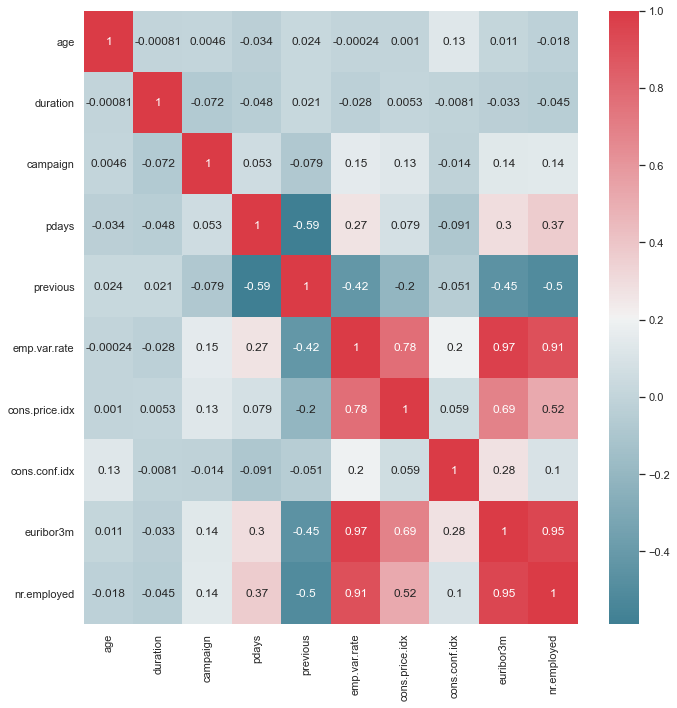

In [7]:
#Heatmap with numeric attributes to check correlations
cmap = sns.diverging_palette(220, 10, as_cmap=True) 
sns.set(style="darkgrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(bank_df[continuous_features].corr(), cmap=cmap, annot=True)
f.tight_layout()

In [8]:
# Cleaning up the dataset by removing old categorical attributes
if 'job' in bank_df:
    del bank_df['job']
if 'marital' in bank_df:
    del bank_df['marital']
if 'default' in bank_df:
    del bank_df['default']
if 'housing' in bank_df:
    del bank_df['housing']
if 'loan' in bank_df:
    del bank_df['loan']
if 'contact' in bank_df:
    del bank_df['contact']
if 'month' in bank_df:
    del bank_df['month']
if 'day_of_week' in bank_df:
    del bank_df['day_of_week']
if 'education' in bank_df:
    del bank_df['education']
if 'poutcome' in bank_df:
    del bank_df['poutcome'] 
    
# Pulling out variables with high correlation to address multicollinearity
if 'nr.employed' in bank_df:
    del bank_df['nr.employed'] 
if 'euriborn3m' in bank_df:
    del bank_df['euriborn3m'] 
if 'emp.var.rate' in bank_df:
    del bank_df['emp.var.rate'] 
if 'cons.price.idx' in bank_df:
    del bank_df['cons.price.idx'] 
if 'previous' in bank_df:
    del bank_df['previous'] 
    

bank_df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            41176 non-null  int64  
 1   duration                       41176 non-null  int64  
 2   campaign                       41176 non-null  int64  
 3   pdays                          41176 non-null  int64  
 4   cons.conf.idx                  41176 non-null  float64
 5   euribor3m                      41176 non-null  float64
 6   y                              41176 non-null  int64  
 7   job_admin.                     41176 non-null  uint8  
 8   job_blue-collar                41176 non-null  uint8  
 9   job_entrepreneur               41176 non-null  uint8  
 10  job_housemaid                  41176 non-null  uint8  
 11  job_management                 41176 non-null  uint8  
 12  job_retired                    41176 non-null 

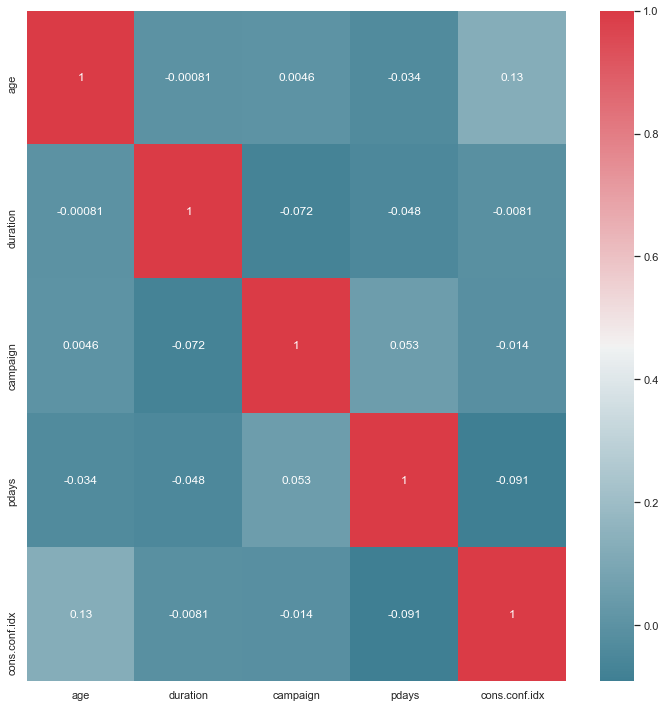

In [9]:
# Checking correlations after removing variables with multicollinearity

# Heatmap formatting
cmap = sns.diverging_palette(220, 10, as_cmap=True) 

sns.set(style="darkgrid")
f, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(bank_df[['age', 'duration', 'campaign', 'pdays','cons.conf.idx']].corr(), cmap=cmap, annot=True)

f.tight_layout()

# Train/Test Split

In [10]:
# Shuffle train test split for cross validation

# Setting up predictions for X and y data
if 'y' in bank_df:
    y = bank_df['y'].values # get the labels we want
    del bank_df['y'] # get rid of the class label
    X = bank_df.values # use everything else to predict!

# Three iterations, run split
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)


ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


# Logistic Regression

In [11]:
# Create logistic regression model, L2 penalty
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None, solver='liblinear' ) # get object

iter_num=0
for train_indices, test_indices in cv_object.split(X,y): 
    
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    lr_clf.fit(X_train,y_train)  # Train model
    y_hat = lr_clf.predict(X_test)

    acc = mt.accuracy_score(y_test,y_hat) # Accuracy
    conf = mt.confusion_matrix(y_test,y_hat) # Confusion matrix
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1


====Iteration 0  ====
accuracy 0.90808644973288
confusion matrix
 [[7117  185]
 [ 572  362]]
====Iteration 1  ====
accuracy 0.9102719766877125
confusion matrix
 [[7109  194]
 [ 545  388]]
====Iteration 2  ====
accuracy 0.9071151044196212
confusion matrix
 [[7084  206]
 [ 559  387]]


In [12]:
# Finding the best parameters for logistic regression

C = [0.1, 2, 5, 10,100]
# L2 penalty
lr_classifiers_results_df = pd.DataFrame(columns = ['C_Param', 'Accuracy', 'Precision', 'Recall', 'F1', 'RunTime'])

for i, c in enumerate(C):
    
    lr_clf = LogisticRegression(penalty='l2', C=c, class_weight=None, solver='liblinear' ) # get object
    for train_indices, test_indices in cv_object.split(X,y): 
        t_start = time.time()
        lr_clf.fit(X[train_indices],y[train_indices])  # Train model
        y_hat = lr_clf.predict(X[test_indices]) # Get test set predictions
        t_end = time.time() - t_start

        accuracy = accuracy_score(y[test_indices], y_hat)
        precision = precision_score(y[test_indices], y_hat)
        recall = recall_score(y[test_indices], y_hat)
        f1score = f1_score(y[test_indices], y_hat)
        classifier_eval = pd.DataFrame([[c, accuracy, precision, recall, f1score, t_end]],
                                       columns = ['C_Param', 'Accuracy', 'Precision', 'Recall', 'F1', 'RunTime'])
        lr_classifiers_results_df = lr_classifiers_results_df.append(classifier_eval, ignore_index = True)

print(lr_classifiers_results_df)

    C_Param  Accuracy  Precision    Recall        F1   RunTime
0       0.1  0.909908   0.657143  0.400871  0.497970  0.393356
1       0.1  0.908451   0.670310  0.391073  0.493960  0.374526
2       0.1  0.911000   0.657092  0.403084  0.499659  0.375521
3       2.0  0.911972   0.653285  0.400896  0.496877  0.322643
4       2.0  0.910272   0.667247  0.411386  0.508970  0.399045
5       2.0  0.909786   0.691120  0.380446  0.490747  0.376556
6       5.0  0.909422   0.617329  0.390411  0.478322  0.325466
7       5.0  0.909301   0.649466  0.398907  0.494245  0.379953
8       5.0  0.912579   0.663669  0.409091  0.506173  0.385566
9      10.0  0.905658   0.647260  0.398314  0.493151  0.316822
10     10.0  0.907358   0.663300  0.411703  0.508059  0.334340
11     10.0  0.907601   0.667235  0.408568  0.506805  0.405448
12    100.0  0.906022   0.630508  0.400862  0.490119  0.307743
13    100.0  0.911122   0.667235  0.421336  0.516513  0.334235
14    100.0  0.909179   0.652651  0.390164  0.488372  0

In [13]:
# L1 penalty 
lr_classifiers_results_df_L1 = pd.DataFrame(columns = ['C_Param', 'Accuracy', 'Precision', 'Recall', 'F1', 'RunTime'])

for i, c in enumerate(C):
    
    lr_clf = LogisticRegression(penalty='l1', C=c, class_weight=None, solver='liblinear' ) # get object
    for train_indices, test_indices in cv_object.split(X,y): 
        t_start = time.time()
        lr_clf.fit(X[train_indices],y[train_indices])  # Train model
        y_hat = lr_clf.predict(X[test_indices]) # Get test set predictions
        t_end = time.time() - t_start

        accuracy = accuracy_score(y[test_indices], y_hat)
        precision = precision_score(y[test_indices], y_hat)
        recall = recall_score(y[test_indices], y_hat)
        f1score = f1_score(y[test_indices], y_hat)
        classifier_eval = pd.DataFrame([[c, accuracy, precision, recall, f1score, t_end]],
                                       columns = ['C_Param', 'Accuracy', 'Precision', 'Recall', 'F1', 'RunTime'])
        lr_classifiers_results_df_L1 = lr_classifiers_results_df_L1.append(classifier_eval, ignore_index = True)

print(lr_classifiers_results_df_L1)

    C_Param  Accuracy  Precision    Recall        F1   RunTime
0       0.1  0.911608   0.677064  0.400651  0.503411  0.700789
1       0.1  0.908694   0.617391  0.400225  0.485636  0.492107
2       0.1  0.905537   0.655766  0.397289  0.494805  0.637620
3       2.0  0.906629   0.663063  0.387368  0.489037  0.969067
4       2.0  0.908694   0.669535  0.409905  0.508497  0.949981
5       2.0  0.913186   0.684588  0.414767  0.516565  1.251860
6       5.0  0.904080   0.645000  0.401452  0.494885  2.113398
7       5.0  0.911729   0.649466  0.407821  0.501030  0.920767
8       5.0  0.914764   0.678322  0.428256  0.525034  1.242059
9      10.0  0.911122   0.676786  0.407527  0.508725  1.209713
10     10.0  0.910879   0.658206  0.422367  0.514550  0.980898
11     10.0  0.907479   0.637838  0.386885  0.481633  1.195616
12    100.0  0.910272   0.661184  0.429947  0.521063  1.090906
13    100.0  0.905537   0.637153  0.392094  0.485450  1.007706
14    100.0  0.908936   0.644097  0.405022  0.497319  1

In [14]:
# Balanced class weight with L2 penalty
lr_classifiers_results_df_balanced = pd.DataFrame(columns = ['C_Param', 'Accuracy', 'Precision', 'Recall', 'F1', 'RunTime'])


for i, c in enumerate(C):
    
    lr_clf = LogisticRegression(penalty='l2', C=c, class_weight='balanced', solver='liblinear' ) # get object
    for train_indices, test_indices in cv_object.split(X,y): 
        t_start = time.time()
        lr_clf.fit(X[train_indices],y[train_indices])  # Train model
        y_hat = lr_clf.predict(X[test_indices]) # Get test set predictions
        t_end = time.time() - t_start

        accuracy = accuracy_score(y[test_indices], y_hat)
        precision = precision_score(y[test_indices], y_hat)
        recall = recall_score(y[test_indices], y_hat)
        f1score = f1_score(y[test_indices], y_hat)
        classifier_eval = pd.DataFrame([[c, accuracy, precision, recall, f1score, t_end]],
                                       columns = ['C_Param', 'Accuracy', 'Precision', 'Recall', 'F1', 'RunTime'])
        lr_classifiers_results_df_balanced = lr_classifiers_results_df_balanced.append(classifier_eval, ignore_index = True)

print(lr_classifiers_results_df_balanced)

    C_Param  Accuracy  Precision    Recall        F1   RunTime
0       0.1  0.860005   0.449893  0.874611  0.594157  0.375047
1       0.1  0.862919   0.448423  0.896368  0.597791  0.434926
2       0.1  0.859276   0.445566  0.879455  0.591470  0.328178
3       2.0  0.857091   0.435106  0.876742  0.581585  0.434210
4       2.0  0.856848   0.431529  0.882736  0.579679  0.414614
5       2.0  0.860369   0.446457  0.883035  0.593064  0.406795
6       5.0  0.860612   0.436819  0.875546  0.582849  0.551318
7       5.0  0.861705   0.436090  0.901221  0.587767  0.524731
8       5.0  0.860248   0.447115  0.878279  0.592566  0.337196
9      10.0  0.863526   0.443784  0.896288  0.593637  0.422385
10     10.0  0.858305   0.440541  0.860612  0.582767  0.469087
11     10.0  0.859519   0.445392  0.878151  0.591022  0.475869
12    100.0  0.861462   0.433128  0.858093  0.575679  0.511745
13    100.0  0.857455   0.430096  0.883772  0.578607  0.374913
14    100.0  0.860855   0.430593  0.887767  0.579912  0

In [15]:
# Change C interactively to see accuracy
def lr_explor(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None,solver='liblinear') # get object
    accuracy = cross_val_score(lr_clf,X,y=y,cv=cv_object) # Set cross validation
    print(accuracy)

wd.interact(lr_explor,cost=(0.001,10.0,0.05),__manual=True)

interactive(children=(FloatSlider(value=4.9510000000000005, description='cost', max=10.0, min=0.001, step=0.05…

<function __main__.lr_explor(cost)>

In [16]:
# Change C interactively to see precision
def lr_explor_p(cost):
    lr_clf = LogisticRegression(penalty='l2', C=cost, class_weight=None,solver='liblinear') # get object
    precision = cross_val_score(lr_clf, X, y, cv=cv_object, scoring='roc_auc') # this also can help with parallelism
    print(precision)

wd.interact(lr_explor_p,cost=(0.001,5.0,0.05),__manual=True)

interactive(children=(FloatSlider(value=2.451, description='cost', max=5.0, min=0.001, step=0.05), Output()), …

<function __main__.lr_explor_p(cost)>

### Logistic Regression Analysis

To find the best performing logistic regression model, we tested the L2 penalty, L1 penalty, a balanced class weight, and multiple C parameter values to compare model statistics. 

Between the L2 and L1 penalties, we see very similar results in terms of accuracy, precision, recall, and F1. 

We tested the balanced class weight model on the L2 penalty, and found a large increase in recall, smaller increase in F1 as well as a decrease in accuracy and precision. "The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))." (Reference: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). Becausse our class 'y' variable is unbalanced, this feature largely changes the statistics of the model. 

To find and compare the different C parameter values, we tested 5 different values for each model scaling from 0.1 to 100. By testing a higher value for C, we attempted to see if the model would overfit to the data. We also created a widget that allows you to see both precision and accuracy as you change the C value dynamically. For our purposes, we chose the model with the unbalanced L2 model with C=10, in order prioritize accuracy and get a slightly higher precision, recall, and F1. In other situations where a higher recall was most important and accuracy was less important, one may choose the balanced model. 

# Interpretting Weights of Logistic Regression

In [17]:
#Normalized weights


# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train) 

X_train_scaled = scl_obj.transform(X_train) 
X_test_scaled = scl_obj.transform(X_test) 

# Train chosen model - TODO: Which C value are we using? Which penalty are we using?
lr_clf = LogisticRegression(penalty='l2', C=10, solver='liblinear') 
lr_clf.fit(X_train_scaled,y_train) 

y_hat = lr_clf.predict(X_test_scaled)

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

# Sorting attributes by weight
zip_vars = zip(lr_clf.coef_.T,bank_df.columns) # Combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) 

accuracy: 0.9072365225837785
[[7081  209]
 [ 555  391]]
euribor3m has weight of -1.0954706144341513
month_may has weight of -0.35665934929874654
pdays has weight of -0.23890807277104395
campaign has weight of -0.13558644999855124
poutcome_failure has weight of -0.1002368530241189
job_blue-collar has weight of -0.08087466907773831
default_unknown has weight of -0.06247173797785531
day_of_week_mon has weight of -0.04865255471560301
education_basic.9y has weight of -0.03309213280835078
default_yes has weight of -0.032958855059962315
job_entrepreneur has weight of -0.026085791894804446
education_basic.4y has weight of -0.02538522965214478
education_high.school has weight of -0.02508308937605947
marital_married has weight of -0.020812963921886918
job_services has weight of -0.020487777893738054
loan_yes has weight of -0.017589965570146433
day_of_week_thu has weight of -0.015494607660529614
month_apr has weight of -0.014789630548458318
job_unknown has weight of -0.014123153025604518
job_self

In [18]:
# Filtering weights for highest and lowest coefficients only
coef = pd.Series(lr_clf.coef_[0],index=bank_df.columns)

posotive = coef[coef > 0.04]
negative = coef[coef < -0.04]

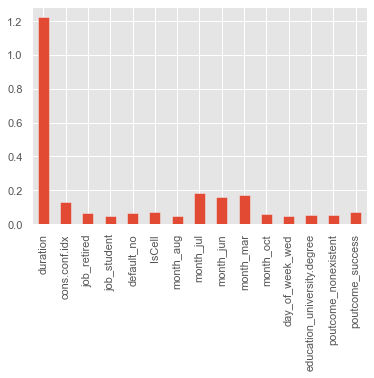

In [19]:
# Plotting weights
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Highest positive coefficients visualization
posotive.plot(kind='bar')
plt.show()

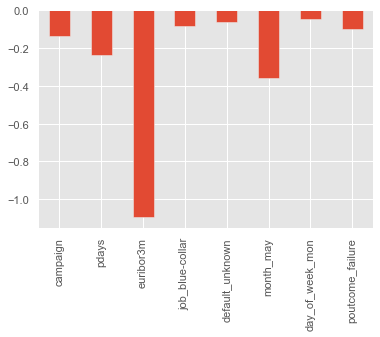

In [20]:
# Lowest negative coefficients visualization
plt.style.use('ggplot')

negative.plot(kind='bar')
plt.show()

### Weight Interpretation

In order to determine the most important factors, we visualized all weights with an absolute value above 0.04. 

Duration had the highest weight value with about 1.2. The duration represents the last contact duration in seconds, refering to how long the last call with the telemarketer lasted. This shows that having a longer final coversation strongly indicates a customer will subscribe to a term deposit. Having a longer duration conversation shows the customer has interest in the term deposit, and this makes practical sense as these conversations could have included discussion of term deposit logistics. 

The month categorical variable also appeared many times in our higher importance weights, specifically with positive weights June through August (0.16, 0.14, 0.07), March (0.16), and October (0.08) and with negative weights, May (-0.36). Customers were more likely to subscribe to a term deposit depending on the month, and less likely to subscribe if it was May. Customers may have felt they had more financial security during the summer months, March, and October. And likewise, could have felt they had less financial security in May. However, this could also be from the higher number of calls during May. In the initial dataset exploration, we saw that almost 2 times more calls occured during May when compared to the other months, so lower liklihood of success could be due to more customers being called. 

The euribor3m weight was the most negative with a value of -1.06. This variable represents the daily indicator of the Euribor 3 month rate. This is a daily reference rate produced by the  by the European Money Markets Institute, based on the averaged interest rates at which Eurozone banks offer to lend unsecured funds to other banks in the euro wholesale money market. This rate could influence or represent the financial security of the customers and therefore make it less likely a customer will subscribe to a term deposit when this value is higher since it represents the interest rates. 

Pdays is the number of days that passed by after the client was last contacted from a previous campaign. A higher value indicates less liklihood that a customer will subscribe to a term deposit. In addition, a pdays value of 999 days represents the customer never previously being contacted. So a higher value most of the time represents they were not contacted or contacted very long ago, and a lower value showing they were previously and more recently contacted for a previous campaign. Being contacted for a previous campaign, particularly recently, shows that it is more likley a customer will subsribe to a term deposit, which making practical sense as a previous repertoire with the customer makes the telemarketing more successful. 

In addition to the important weights listed above, having a cell phone compared to a telephone indicates a higher liklihood of subscribing to a term deposit. Being retired indicates a higher liklihood of subscribing to a term deposit. Having a university degree indicates a higher liklihood of subscribing to a term deposit. Having a blue collar job indicates a lower liklihood of subscribing to a term deposit. A last contact date on Monday indicates a lower liklihood of subscribing to a term deposit. 

# SVM

In [21]:
# Train and test split for SVM

# Selecting features based on Logit resutls most important features
feature_select = ['duration', 'month_mar', 'month_jun', 'month_jul','cons.conf.idx', 'poutcome_success','job_retired']

X_train_svm,X_test_svm,y_train, y_test = train_test_split(bank_df[feature_select] , y ,  test_size=0.2,random_state=11)

# Normalize
scl_obj = StandardScaler()
scl_obj.fit(X_train_svm)

X_train_scaled_svm = scl_obj.transform(X_train_svm)
X_test_scaled_svm = scl_obj.transform(X_test_svm) 

In [22]:
# Running SVM on the data with multiple C and gamma parameters

C = [0.1, 2, 5, 10,100]
G = [1, 5, 10]


svm_classifiers_results_df = pd.DataFrame(columns = ['C_Param', 'G_Param','Accuracy', 'Precision', 'Recall', 'F1', 'RunTime'])

for i, c in enumerate(C):
    print("c:",c)
    for j, g in enumerate(G):
        print("g:",g)
        svm_clf = SVC(C=c, kernel='rbf', gamma=g)

        for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
            t_start = time.time() # Start timer to measure time
            svm_clf.fit(X_train_scaled_svm, y_train) # Train SVM model
            y_hat = svm_clf.predict(X_test_scaled_svm) # Get test set predictions for SVM
            t_end = time.time() - t_start # End timer

            accuracy = accuracy_score(y_test, y_hat)
            precision = precision_score(y_test, y_hat)
            recall = recall_score(y_test, y_hat)
            f1score = f1_score(y_test, y_hat)
            classifier_eval = pd.DataFrame([[c, g, accuracy, precision, recall, f1score, t_end]],
                                           columns = ['C_Param', 'G_Param','Accuracy', 'Precision', 'Recall', 'F1', 'RunTime'])
            svm_classifiers_results_df = svm_classifiers_results_df.append(classifier_eval, ignore_index = True)

c: 0.1
g: 1
g: 5
g: 10
c: 2
g: 1
g: 5
g: 10
c: 5
g: 1
g: 5
g: 10
c: 10
g: 1
g: 5
g: 10
c: 100
g: 1
g: 5
g: 10


In [23]:
print(svm_classifiers_results_df)

    C_Param G_Param  Accuracy  Precision    Recall        F1      RunTime
0       0.1       1  0.909422   0.644483  0.403952  0.496626    23.807890
1       0.1       1  0.909422   0.644483  0.403952  0.496626    26.177693
2       0.1       1  0.909422   0.644483  0.403952  0.496626    23.167602
3       0.1       5  0.911243   0.655172  0.417124  0.509725    24.502594
4       0.1       5  0.911243   0.655172  0.417124  0.509725    22.311223
5       0.1       5  0.911243   0.655172  0.417124  0.509725    21.281763
6       0.1      10  0.908815   0.651515  0.377607  0.478110    27.732505
7       0.1      10  0.908815   0.651515  0.377607  0.478110    28.087924
8       0.1      10  0.908815   0.651515  0.377607  0.478110    21.877088
9       2.0       1  0.911850   0.646130  0.448957  0.529793    29.064780
10      2.0       1  0.911850   0.646130  0.448957  0.529793    25.103083
11      2.0       1  0.911850   0.646130  0.448957  0.529793    21.605277
12      2.0       5  0.913307   0.6343

In [24]:
# Choose best model for SVM

svm_clf = SVC(C=2, kernel='rbf', gamma=10)
svm_clf.fit(X_train_scaled_svm, y_train)  # train object
y_hat = svm_clf.predict(X_test_scaled_svm)

### SVM Model

Because we have over 60 features and a very large dataset, we chose the most important variables as determined by the logistic regression above for the SVM modeling. By reducing the attributes in the dataet, the runtime will be significantly reduced. 

During our exploratory analysis, we also saw through PCA that there was no clear separation by class in our dataset when looking at the numerical variables. Due to this we used an RBF kernel rather than linear kernel. 

To find the best parameters for our dataset, we ran an SVM model for 5 different C values and 3 different gamma values. After looking at the statistics for each model, we chose C=2 and gamma=10 because this model had a slightly higher statistics overall including accuracy, recall, and F1. 

We also looked at runtime for each model, as SVM for a dataset this large with this many attributes takes a lot of time. The models with the highest runtime were those with C=100, and that value decreases as C goes down. This was also an advantage of the C=2 model. When comparing these SVM models to logistic regression, however, all of the runtimes are much longer for SVM even considering our logistic regression ran the full dataset and SVM only ran 7 attributes. 

In [25]:
# Look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(7315, 7)
(7315,)
[4237 3078]


In [26]:
# Analysis of support vectors chosen

# Training dataframe
df_tested_on = bank_df.iloc[train_indices].copy() 
df_support = df_tested_on.iloc[svm_clf.support_,:].copy() # Support vectors

df_support['y'] = y[svm_clf.support_] # Add class 'y' to dataframe
bank_df['y'] = y # Add class 'y' to original dataframe
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7315 entries, 32666 to 27412
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            7315 non-null   int64  
 1   duration                       7315 non-null   int64  
 2   campaign                       7315 non-null   int64  
 3   pdays                          7315 non-null   int64  
 4   cons.conf.idx                  7315 non-null   float64
 5   euribor3m                      7315 non-null   float64
 6   job_admin.                     7315 non-null   uint8  
 7   job_blue-collar                7315 non-null   uint8  
 8   job_entrepreneur               7315 non-null   uint8  
 9   job_housemaid                  7315 non-null   uint8  
 10  job_management                 7315 non-null   uint8  
 11  job_retired                    7315 non-null   uint8  
 12  job_self-employed              7315 non-nul

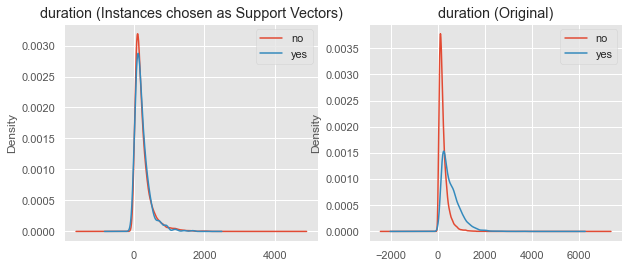

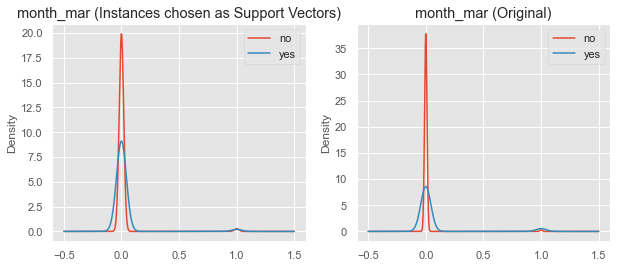

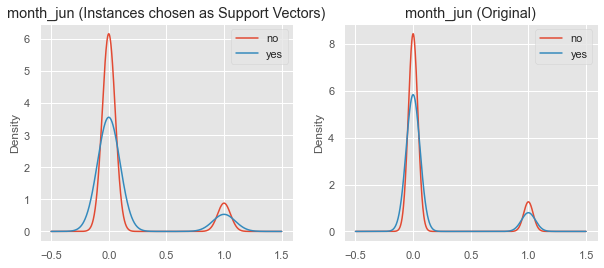

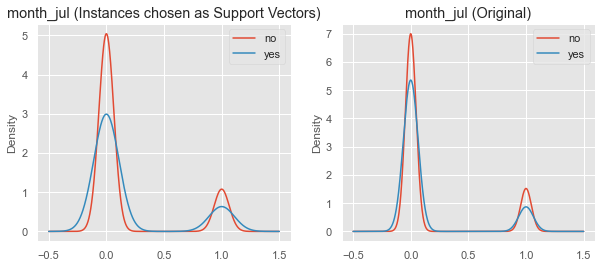

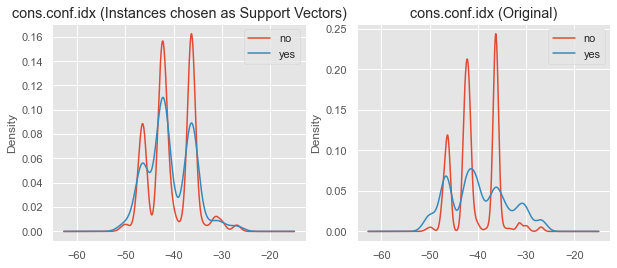

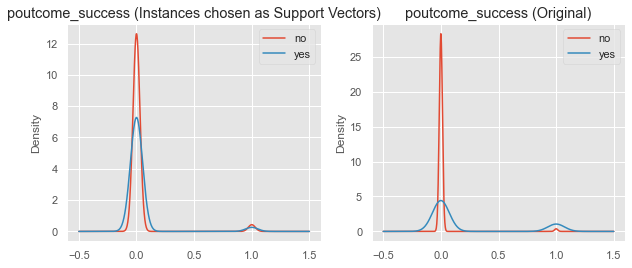

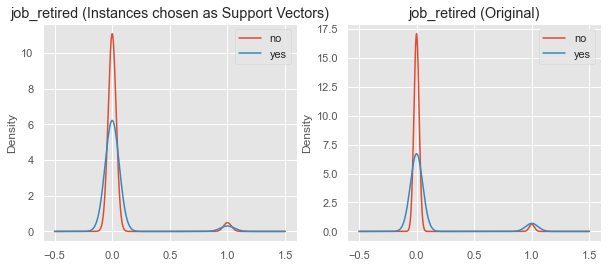

In [27]:
# Support vector analysis

# Group the original data and the support vectors
df_grouped_support = df_support.groupby(['y'])
df_grouped = bank_df.groupby(['y'])

# Plot kernal density estimation of attributes
vars_to_plot = feature_select

for v in vars_to_plot:
    plt.figure(figsize=(10,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['no','yes']) # assuming survived=1
    plt.title(v+' (Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['no','yes'])
    plt.title(v+' (Original)')


### Support Vectors

From our chosen model we have 7315 support vectors, with a class separation of 4237 and 3078. 

In order to visualize the model, we plotted the kernal density estimations of each attribute. On the left are the instances chosen as support vectors and on the right is the original data, all separated by class. Not subscribing to a term deposit is seen in red and subscribing is seen in blue. 

In the duration graphs, the support vector plot has a much higher 'yes' spike. The 'yes' and 'no' peaks for the duration support vector plot are much closer together than the plot of the original data. For the month of March, we also see a similar instance of the support vector data peaks being much closer between the 'yes' and 'no' values. The original plot also has a much higher peak in 'no' and a much lower peak with wider spread for 'yes' compared to the support vector plot. For the month of June and July, there are peaks at 0 and at 1 in both graphs from both classes, but the original data plots reach higher values for both the 'yes' and 'no' classes. Cons.conf.idx has many peaks across x values, but the 'yes' and 'no' support vector peaks are much closer in value, and the 'yes' values are higher with a narrower spread and the 'no' values are lower. The poutcome original data reaches a much higher 'no' peak compared to the support vector 'no' peak, and the original 'yes' peak is much lower than the support vector's with a wider spread. Lastly, in the job retired plots the 'yes' and 'no' peaks are closer together in value in the support vector plot, and the 'no' peak does not reach as high as the original data plot. 

These plot comparisons show us what the original data looks like compared to our support vector statistics. Across all the plots in general, we see the separation of the distributions based on class is smaller in the support vector plots. This is expected as the support vectors represent both the incorrect classifications and the instances on the extreme side of the class boundaries. (Reference: 04. Logits and SVM notebook by Professor Eric Larson)

### Comparing the Logistic Model with SVM

Our final logistic model used the L2 penalty, unbalanced class weights, and C=10. We created this model from the full dataset. Our final SVM model used RBF kernel, C=2, and gamma=10. We created this model from a subset of the data, with the most important attributes as determined by the logistic regression model. 

| Model      | Accuracy | Precision | Recall | F1 | Runtime |
| ----------- | ----------- | ----------- | ----------- | ----------- | ----------- |
| **Logistic Regression** (2nd iteration) | 0.912336 | 0.673874 | 0.408743 | 0.508844 | 0.276004 |
| **SVM**  (2nd iteration) | 0.913550 | 0.630406 | 0.527991  | 0.574671 | 23.886547 |

Both models had around the same accuracy, with SVM slightly higher by about 0.001. Precision was about 0.04 higher in the logistic regression model, recall was about 0.12 higher in the SVM model, and F1 was about 0.07 higher in the SVM model. In terms of these statistics, most were pretty close in value; however, recall had a larger jump in the SVM model. Looking at the runtime of the models, the SVM model took significantly more time to run, and it should be taken into consideration that the model ran with only 7 attributes out of around 60. 

The models performed very similarly, with the largest differences seen in recall and runtime. In choosing a model, there are significant runtime advantages to a logistic regression model. If recall was very important to your purposes or goals, you may want to take the extra time in using the SVM model. 

In general, SVM also provides advantages when dealing with data that is not linearly separated by using the different kernel options. It also helps in cases where the class variable is unbalanced, like in our case, and in situations of large outliers. 


In [28]:
# End timer and print total time
global_t_end = time.time() - global_t_start
print(global_t_end)

#***Runtime is actually 1610 seconds (about 27 minutes), this value was due to computer falling asleep while running

5300.750460147858
